# Plot

In [6]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
import pylhe, gzip, tempfile
from getInfoFromBanner import getInfo

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [3]:
files = list(glob.glob('../processFolders/*/Events/*/unweighted_events.lhe.gz'))
# files = [f for f in files[:] if not (('gg2TT_formFactors' in f) and ('run_04' not in f))]
# print(files)

In [4]:
# Get info
fileData = {f : getInfo(f) for f in files}

allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
print(allModels)
print(allPars)
print(allProcesses)

['1-loop', 'EFT', 'SM']
[(600.0, 550.0, 172.5, 1.0), (2000.0, 1900.0, 172.5, 1.0)]
['$g g \\to \\bar{t} t$', '$q q \\to \\bar{t} t$']


In [5]:
# Select files:
models = ['SM','EFT']
pars = [(600.,550.,172.5,1.0)]
procs = allProcesses[:]

bsmFiles = []
smFiles = []
for f,fInfo in fileData.items():
    if fInfo['model'] not in models:
        continue
    if fInfo['process'] not in procs:
        continue
        
    if fInfo['model'] == 'SM':
        smFiles.append(f)
    else:
        if fInfo['(mST,mChi,mT,yDM)'] not in pars:
            continue
        bsmFiles.append(f)
    
# print(bsmFiles)
# print(smFiles)
# Sort files so largest cross-sections come first
bsmFiles = sorted(bsmFiles, key = lambda f: fileData[f]['xsec (pb)'], reverse=True)
smFiles = sorted(smFiles, key = lambda f: fileData[f]['xsec (pb)'], reverse=True)
selectedFiles = smFiles+bsmFiles

In [7]:
# It is necessary to remove the < signs from the LHE files (in the generate line) before parsing with pylhe
events = {}
for fpath in selectedFiles:
    fixedFile = tempfile.mkstemp(suffix='.lhe')
    os.close(fixedFile[0])
    fixedFile = fixedFile[1]
    with  gzip.open(fpath,'rt') as f:
        data = f.readlines()
        with open(fixedFile,'w') as newF:
            for l in data:
                if 'generate' in l:
                    continue
                newF.write(l)
    events[fpath] = pylhe.read_lhe_with_attributes(fixedFile)

In [8]:
mtt = {}
mcTotal = {f : 0 for f in selectedFiles}
weightsDict = {f : [] for f in selectedFiles}
for f,r in events.items():
    pT1 = []
    pT2 = []
    mTT = []
    for iev,ev in enumerate(r):
        weightsDict[f].append(ev.eventinfo.weight)
        mcTotal[f] += 1
        for ptc in ev.particles:
            if abs(ptc.id) != 6: continue
            if ptc.id == 6:
                pA = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])
            else:
                pB = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])

        pT1.append(max(np.linalg.norm(pA[0:3]),np.linalg.norm(pB[0:3])))
        pT2.append(min(np.linalg.norm(pA[0:3]),np.linalg.norm(pB[0:3])))
        mTT.append(np.sqrt((pA[-1]+pB[-1])**2-np.linalg.norm(pA[0:3]+pB[0:3])**2))
    mtt[f] = {'pT1' : pT1, 'pT2' : pT2, 'mTT' : mTT}

In [9]:
for f,w in weightsDict.items():
    weightsDict[f] = np.array(w)/mcTotal[f]
    print('\n %s : %s' %(fileData[f]['model'],fileData[f]['process']))
    print('total xsec    = ',sum(weightsDict[f]))
    # print('  (from file) = ',fileData[f]['xsec (pb)'])


 SM : $g g \to \bar{t} t$
total xsec    =  440.74727431240785

 SM : $q q \to \bar{t} t$
total xsec    =  64.49007694093635

 EFT : $q q \to \bar{t} t$
total xsec    =  0.0060678185801170325

 EFT : $g g \to \bar{t} t$
total xsec    =  -0.057222215529771844


In [10]:
# Define colors
colors = {f : sns.color_palette('deep')[i] for i,f in enumerate(mtt.keys())}

In [11]:
# Define scale factor (new yDM value)
kscales = {f : 1.0 for f in smFiles}
kscales.update({f : 1000 for f in bsmFiles})

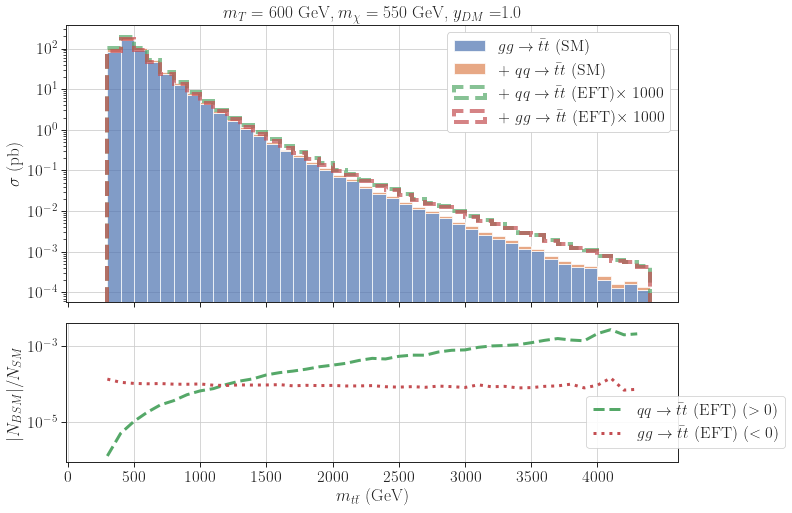

In [12]:
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
bins = np.arange(200.,4500.,100.)

labels = []
pmodels = []
hists = []
histsErr = []
c = []
ks = []
for f in mtt:
    process = fileData[f]['process']
    model = fileData[f]['model']
    mST,mChi,mT,yDM = fileData[f]['(mST,mChi,mT,yDM)']
    
    kscale = kscales[f]
#     if f in bsmFiles:
#         continue
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    if labels:
        label = ' + ' + label
    if kscale != 1.0:
        label += r'$ \times $ %1.0f' %kscale
    labels.append(label)
    c.append(colors[f])
    ks.append(kscale)
    h,_ = np.histogram(mtt[f]['mTT'],bins=bins,weights=kscale*weightsDict[f])
    hists.append(h)
    #Compute MC error
    hErr,_ = np.histogram(mtt[f]['mTT'],bins=bins,weights=(kscale*weightsDict[f])**2)
    hErr = np.sqrt(hErr)    
    histsErr.append(hErr)
    

histsSM = [h for i,h in enumerate(hists) if 'SM' in labels[i]]    
histsErrSM = [h for i,h in enumerate(histsErr) if 'SM' in labels[i]]
labelsSM = [l for i,l in enumerate(labels) if 'SM' in labels[i]]    
cSM =  [cc for i,cc in enumerate(c) if 'SM' in labels[i]]    
axarr[0].hist([bins[:-1]]*len(histsSM),label=labelsSM,bins=bins,
                          weights=histsSM,alpha=0.7,
                          density=False,linewidth=1,color=cSM,stacked=True)

hSM = sum([hh for hh in histsSM[:]])
hErrSM = np.sqrt(sum([hh**2 for hh in histsErrSM[:]]))
hTot = np.copy(hSM)
labelsTrack = []
for i,h in enumerate(hists):
    if 'SM' in labels[i]:
        continue    
    hTot += h
    axarr[0].hist(bins[:-1],weights=hTot,label=labels[i],bins=bins,
                  color=c[i],alpha=0.7,histtype='step',
                  linewidth=4,fill=False,zorder=i,linestyle='--')


    # Compute ratio (keeping negative and positive values)
    ratio = np.divide(h/ks[i], hSM, out=np.zeros_like(np.abs(h)),where=hSM != 0)
    # Remove zero values
    nonzero = np.where((np.sign(ratio) != 0))
    x = bins[:-1][nonzero]
    y = ratio[nonzero]
    # Split curves into positive and negative segments
    xy = np.array(list(zip(x,y)))
    for xySplit in np.split(xy,np.where(y[:-1]/y[1:]<0)[0]+1):
        if xySplit[0,1] < 0: # negative values
            ls = 'dotted'
            label = pmodels[i]+r' ($<0$)'
        else:
            ls = 'dashed'
            label = pmodels[i]+r' ($>0$)'
            
        if label not in labelsTrack:
            labelsTrack.append(label)
        else:
            label = None
        axarr[1].plot(xySplit[:,0],np.abs(xySplit[:,1]),linewidth=3.0,linestyle=ls, 
                          label=label,c=c[i])
    


    
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-4,500)
axarr[0].set_xticks(np.arange(0.,bins.max(),500))
# axarr[0].set_xlim(250,1500)
axarr[1].set_xlabel(r'$m_{t\bar{t}}$ (GeV)')
axarr[0].set_ylabel(r'$\sigma$ (pb)')
axarr[1].set_ylabel(r'$|N_{BSM}|/N_{SM}$')
# axarr[1].set_ylim(1e-3,1)
axarr[1].set_yscale('log')
axarr[0].grid()
axarr[1].grid()


axarr[0].legend(framealpha=1.0)
axarr[1].legend(framealpha=0.9,loc=(0.85,0.1))
axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM))
plt.show()

### Just the BSM contributions (with MC errors)

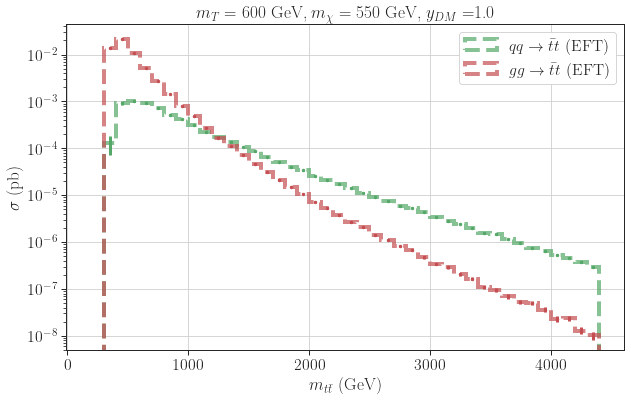

In [13]:
_, ax = plt.subplots(1,figsize=(10,6))
    
for i,h in enumerate(hists):
    if 'SM' in labels[i]:
        continue    
    hErr = histsErr[i]/ks[i]
    hAbs = np.abs(h)/ks[i]
    ax.hist(bins[:-1],weights=hAbs,label=pmodels[i],bins=bins,
                  color=c[i],alpha=0.7,histtype='step',
                  linewidth=4,fill=False,zorder=i,linestyle='--')

    
    bincenters = 0.5*(bins[1:]+bins[:-1])
    ax.errorbar(bincenters,hAbs,yerr=hErr, marker = '.', elinewidth=3.0,
                 drawstyle = 'steps-mid',linewidth=0.0,color=c[i],alpha=1.0)

    
ax.set_yscale('log')
# ax.set_ylim(1-5,1)
# ax.set_xlim(1000,1500)
ax.set_ylabel(r'$\sigma$ (pb)')
ax.set_xlabel(r'$m_{t\bar{t}}$ (GeV)')
ax.grid()

ax.legend(framealpha=1.0)
ax.set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM))
plt.show()